In [17]:
# Import Dependencies
import matplotlib
from matplotlib import style
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

 # Import SQLAlchemy `automap` and other dependencies here
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

# Import datetime
import datetime as dt

In [3]:
 # Create an engine for the `hawaii.sqlite` database
engine = create_engine("sqlite:///hawaii.sqlite", echo=False)

In [4]:
# Prepare and Reflect the Database using Base
Base = automap_base()
Base.prepare(engine, reflect=True)

In [5]:
# Print all the class mapped to the Base
Base.classes.keys()

['measurements', 'station']

In [6]:
# Create inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurements', 'station']

In [7]:
# Select and display the first 10 rows of the table
engine.execute('SELECT * FROM measurements LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (6, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (7, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (8, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (9, 'USC00519397', '2010-01-11', 0.01, 64.0),
 (10, 'USC00519397', '2010-01-12', 0.0, 61.0)]

In [8]:
# Reflect Database into ORM class
Station = Base.classes.station
Measurements = Base.classes.measurements

In [9]:
# Start a session to query the database
session = Session(engine)

In [10]:
# PRECIPITATION ANALYSIS

# Grab last entry in table
last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date)

(datetime.date(2017, 8, 23),)


In [11]:
# Get the last 12 months of data, last date - 365
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [12]:
# Query to retrieve the last 12 months of precipitation data
rain = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

In [13]:
# Load data from query to dataframe
rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,1.22
4,2016-08-24,2.15


In [14]:
# Reset index to date column
rain_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,1.22
2016-08-24,2.15


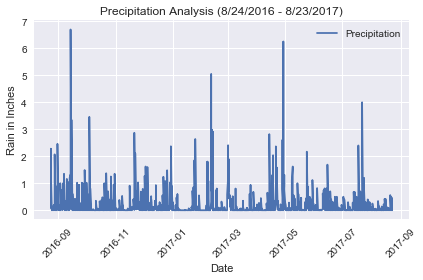

In [22]:
# Plot rain_df
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/2016 - 8/23/2017)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()

fig = plt.figure()
fig.savefig('precipitation_analysis.png')

plt.show()

In [24]:
# Summary Statistics of Precipitaiton Data
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [25]:
# STATION ANALYSIS

# Total number or stations in Measurement table
locations = session.query(Measurements).group_by(Measurements.station).count()
print(f"There are {locations} stations.")

There are 9 stations.


In [26]:
# List the stations and observation counts in descending order
# Which station has the highest number of observations
busy_station = session.query(Measurements.station, func.count(Measurements.tobs)).\
                            group_by(Measurements.station).\
                            order_by(func.count(Measurements.tobs).desc()).all()

busiest = busy_station[0][0]
print(f"The busiest station was {busiest} with {busy_station[0][1]}, weather observations")
print("------------------------------------------------------")
print("Stations and number of observations in descending order: ")
for station, count in busy_station:
    print(f"Station {station} had {count} weather observations.")

The busiest station was USC00519281 with 2772, weather observations
------------------------------------------------------
Stations and number of observations in descending order: 
Station USC00519281 had 2772 weather observations.
Station USC00513117 had 2696 weather observations.
Station USC00519397 had 2685 weather observations.
Station USC00519523 had 2572 weather observations.
Station USC00516128 had 2484 weather observations.
Station USC00514830 had 1937 weather observations.
Station USC00511918 had 1932 weather observations.
Station USC00517948 had 683 weather observations.
Station USC00518838 had 342 weather observations.


In [27]:
# Query to pull the last year of precipitation data for the busiest station
temp = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == busiest).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

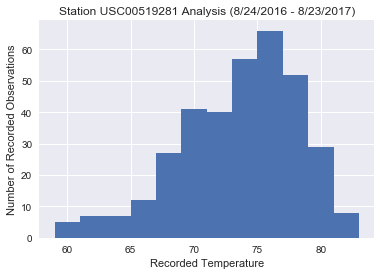

In [28]:
# Plot temp data in histogram with 12 bins
temp_df = pd.DataFrame(temp)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title(f"Station {busiest} Analysis (8/24/2016 - 8/23/2017)")

fig = plt.figure()
fig.savefig('busiest_station_analysis.png')

plt.show()

In [29]:
# TEMPERATURE ANALYSIS

# Write a function called calc_temps that will accept a start date and end date in the format 
#%Y-%m-%d and return the minimum, average, and maximum temperatures for that range of dates.
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurements.tobs), func.avg(Measurements.tobs), func.max(Measurements.tobs)).\
        filter(Measurements.date >= start_date).filter(Measurements.date <= end_date).all()
temp_range = (calc_temps('2016-07-05', '2016-07-28'))
print(temp_range)

[(71.0, 77.34848484848484, 83.0)]


In [30]:
# Calculate min/max/avg temps form last year that matches my trip date
trip_start = dt.date(2018, 8, 1)
trip_end = dt.date(2018, 8, 15)
year_ago = dt.timedelta(days=365)
temp_avg_last_year = (calc_temps((trip_start - year_ago), (trip_end - year_ago)))
print(temp_avg_last_year)

[(70.0, 79.0909090909091, 84.0)]


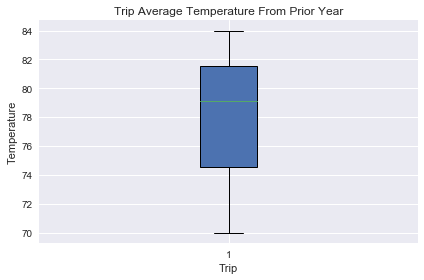

In [33]:
# Plotting the data as a boxplot (to show min/max/avg temps)
fig, ax = plt.subplots()
x = range(len(temp_avg_last_year))
ax.boxplot(temp_avg_last_year, patch_artist=True)
ax.set_title('Trip Average Temperature From Prior Year')
ax.set_ylabel("Temperature")
ax.set_xlabel("Trip")
fig.tight_layout()
plt.show()

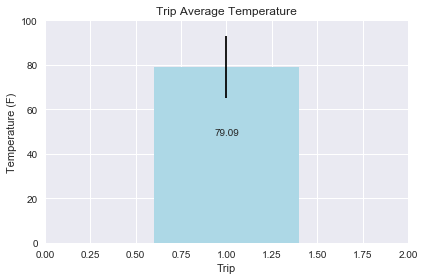

In [35]:
# Plot the calculated min/max/avg from last year for the trip dates as a bar chart

p2p = temp_avg_last_year[0][2]-temp_avg_last_year[0][0]
avgtemp = temp_avg_last_year[0][1]
min_temp = temp_avg_last_year[0][0]
max_temp = temp_avg_last_year[0][2]

fig, ax = plt.subplots()
bar_chart = ax.bar(1 , avgtemp, color= 'lightblue', yerr=p2p)
ax.set_xlabel("Trip")
ax.set_ylabel("Temperature (F)")
ax.set_title("Trip Average Temperature")

def autolabels(rects):
   for rect in rects:
        h=rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., .6*h,'%.2f' % float(h) ,ha='center', va='bottom', fontsize=10)

        
    # label the bars 
autolabels(bar_chart)        
plt.ylim(0, 100)
plt.xlim(0,2)
fig.tight_layout()

fig = plt.figure()
fig.savefig('trip_avg_temp.png')

plt.show()

In [36]:
# EXTRA ANALYSIS
Rainfall_results = session.query(Measurements.station, func.count(Measurements.prcp)).\
                   group_by(Measurements.station).filter(Measurements.date.between('2016-08-01', '2017-08-01')).all()
Rainfall_results

[('USC00513117', 365),
 ('USC00514830', 261),
 ('USC00516128', 331),
 ('USC00517948', 67),
 ('USC00519281', 365),
 ('USC00519397', 361),
 ('USC00519523', 320)]

In [37]:
from sqlalchemy import extract  
trip_month=8
trip_days=range(1, 16)
for i in range(1, 16):
    subquery=session.query(Measurements.date).filter(extract('month', Measurements.date)==trip_month).\
             filter(extract('day', Measurements.date)== i ).group_by(Measurements.date).order_by(Measurements.date).all()
subquery

[(datetime.date(2010, 8, 15)),
 (datetime.date(2011, 8, 15)),
 (datetime.date(2012, 8, 15)),
 (datetime.date(2013, 8, 15)),
 (datetime.date(2014, 8, 15)),
 (datetime.date(2015, 8, 15)),
 (datetime.date(2016, 8, 15)),
 (datetime.date(2017, 8, 15))]

In [38]:
dates=[]
daily_normals_Three_AVG=[]
daily_normals_TMAX=[]
daily_normals_TMIN=[]
daily_normals_TAVG=[]

trip_month=8
trip_days=range(1, 16)

def daily_normals():
    
    for i in range(1,16):
        results=session.query(Measurements.date.label("dates"), func.max(Measurements.tobs).label("max_tobs"),\
                             func.min(Measurements.tobs).label("min_tobs"),func.avg(Measurements.tobs).label("avg_tobs")).\
                             filter(extract('month', Measurements.date)==trip_month).\
                             filter(extract('day', Measurements.date)== i ).group_by(Measurements.date).order_by(Measurements.date)
        results
        for res in results.all():
             print( res)
        
        res
        TMAX = res.max_tobs
        TMIN= res.min_tobs
        TAVG= res.avg_tobs
        Date= res.dates
        
        data = [TMAX, TMIN, TAVG]
        #avg = [float(sum(col))/len(col) for col in zip(*data)]

        dates.append(Date)
        #daily_normals_Three_AVG.append(avg)
        daily_normals_TMAX.append(TMAX)
        daily_normals_TMIN.append(TMIN)
        daily_normals_TAVG.append(TAVG)
        
daily_normals()

(datetime.date(2010, 8, 1), 77.0, 71.0, 73.42857142857143)
(datetime.date(2011, 8, 1), 78.0, 67.0, 73.28571428571429)
(datetime.date(2012, 8, 1), 79.0, 71.0, 75.85714285714286)
(datetime.date(2013, 8, 1), 79.0, 75.0, 76.83333333333333)
(datetime.date(2014, 8, 1), 83.0, 73.0, 77.42857142857143)
(datetime.date(2015, 8, 1), 79.0, 73.0, 77.4)
(datetime.date(2016, 8, 1), 77.0, 73.0, 75.8)
(datetime.date(2017, 8, 1), 77.0, 74.0, 75.33333333333333)
(datetime.date(2010, 8, 2), 76.0, 70.0, 72.875)
(datetime.date(2011, 8, 2), 77.0, 70.0, 73.57142857142857)
(datetime.date(2012, 8, 2), 78.0, 68.0, 73.5)
(datetime.date(2013, 8, 2), 78.0, 72.0, 75.33333333333333)
(datetime.date(2014, 8, 2), 81.0, 73.0, 77.71428571428571)
(datetime.date(2015, 8, 2), 84.0, 76.0, 80.0)
(datetime.date(2016, 8, 2), 80.0, 72.0, 76.57142857142857)
(datetime.date(2017, 8, 2), 83.0, 73.0, 79.0)
(datetime.date(2010, 8, 3), 77.0, 70.0, 73.11111111111111)
(datetime.date(2011, 8, 3), 78.0, 71.0, 75.25)
(datetime.date(2012, 8, 3)

In [39]:
# Create DataFrame
Daily_normals_df= pd.DataFrame({'Date': dates, 'TMAX': daily_normals_TMAX, 'TMIN': daily_normals_TMIN,'TAVG': daily_normals_TAVG,})

# Reset Index
Daily_normals_df.set_index('Date', inplace=True, )

Daily_normals_df.head()

,TAVG,TMAX,TMIN
Date,,,
2017-08-01,75.333333,77.0,74.0
2017-08-02,79.000000,83.0,73.0
2017-08-03,79.000000,81.0,76.0
2017-08-04,80.000000,82.0,77.0
2017-08-05,81.500000,82.0,81.0


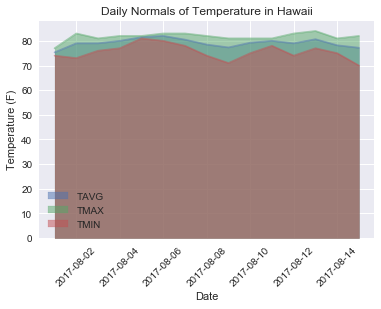

In [40]:
# Plot Graph
Daily_normals_df.plot.area(stacked=False, title='Daily Normals of Temperature in Hawaii')
plt.xlabel('Date')
plt.ylabel('Temperature (F)')
plt.xticks(rotation=45)

fig = plt.figure()
fig.savefig('daily_normals_temp.png')

plt.show()